# **EDA Notebook**



---
## 0. Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT3",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
Mounted at /content/gdrive

You can now save your data files in: /content/gdrive/MyDrive/36106/assignment/AT3/data


---
## Student Information

In [2]:
# <Student to fill this section>
group_name = "Group 12"
student_name = "Victor Rono"
student_id = "25669944"

In [3]:
# Do not modify this code
print_tile(size="h1", key='group_name', value=group_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [ ]:
# <Student to fill this section>

### 0.b Import Packages

In [6]:
# <Student to fill this section>
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt

---
## B. Data Understanding

In [7]:
# Do not modify this code
try:
  df = pd.read_csv(at.folder_path / "sales_2021.csv")
except Exception as e:
  print(e)

### B.1 Explore Dataset

{'rows': 53610, 'cols': 14, 'duplicates': 0}


,Unnamed: 0,order_date,stock_date,order_number,product_key,customer_key,territory_key,order_line_item,order_quantity,OrderDate,ProductKey,CustomerKey,OrderNumber,ym
0,0,2021-09-21,2021-08-16,SO54754,487,11304,1,3,1,NaN,NaN,NaN,NaN,2021-09-01
1,1,2021-12-21,2021-08-27,SO60490,232,12259,10,1,1,NaN,NaN,NaN,NaN,2021-12-01
2,2,2021-08-25,2021-06-03,SO53070,539,14516,9,1,2,NaN,NaN,NaN,NaN,2021-08-01
3,3,2021-09-11,2021-07-20,SO54170,528,11973,1,2,1,NaN,NaN,NaN,NaN,2021-09-01
4,4,2021-09-19,2021-07-22,SO54642,220,19021,1,4,1,NaN,NaN,NaN,NaN,2021-09-01


Top-10 missingness (%):


,column,missing_pct
0,OrderNumber,100.0
1,OrderDate,100.0
2,ProductKey,100.0
3,CustomerKey,100.0
4,Unnamed: 0,0.0
5,order_date,0.0
6,customer_key,0.0
7,product_key,0.0
8,order_number,0.0
9,stock_date,0.0


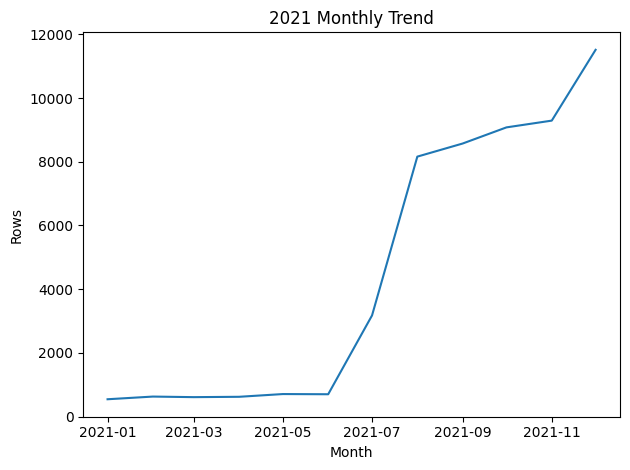

In [17]:
dfw = df.copy()  # safe copy

# tolerant column picker for common names
def pick(cols, cands):
    low = {c.lower(): c for c in cols}
    for c in cands:
        if c in cols: return c
        if c.lower() in low: return low[c.lower()]
    return None

cols = list(dfw.columns)

# typical columns (tolerant to case/aliases)
date_col  = pick(cols, ["order_date","OrderDate","Date","date","invoice_date"]) # Changed the order to prioritize 'order_date'
qty_col   = pick(cols, ["OrderQuantity","order_qty","quantity","Qty","qty", "order_quantity"])
price_col = pick(cols, ["UnitPrice","unit_price","price","ListPrice","list_price"])
tot_col   = pick(cols, ["LineTotal","line_total","Sales","sales","Revenue","revenue","Amount","amount"])
terr_col  = pick(cols, ["SalesTerritoryKey","territory_id","TerritoryID","territory"])
prod_col  = pick(cols, ["product_key","ProductKey","ProductID","product_id"]) # Prioritized 'product_key'
cust_col  = pick(cols, ["CustomerKey","customer_key","CustomerID","customer_id"])

# type coercions + helpful derived fields
if date_col is not None:
    dfw[date_col] = pd.to_datetime(dfw[date_col], errors="coerce")
    dfw["ym"] = dfw[date_col].dt.to_period("M").dt.to_timestamp()

for c in [qty_col, price_col, tot_col]:
    if c is not None:
        dfw[c] = pd.to_numeric(dfw[c], errors="coerce")

# derive revenue when missing but qty and price exist
if tot_col is None and (qty_col is not None) and (price_col is not None):
    dfw["revenue"] = dfw[qty_col] * dfw[price_col]
    tot_col = "revenue"

# structure and quality snapshot
print({"rows": len(dfw), "cols": dfw.shape[1], "duplicates": int(dfw.duplicated().sum())})
display(dfw.head(5))

miss = (dfw.isna().mean().sort_values(ascending=False)*100).round(1).reset_index()
miss.columns = ["column","missing_pct"]
print("Top-10 missingness (%):")
display(miss.head(10))

# quick monthly trend (revenue if available; else rows)
if "ym" in dfw.columns:
    if tot_col is not None:
        m = dfw.groupby("ym")[tot_col].sum().reset_index()
        ylab, vals = "Revenue", m[tot_col]
    else:
        m = dfw.groupby("ym").size().reset_index(name="rows")
        ylab, vals = "Rows", m["rows"]
    plt.figure()
    plt.plot(m["ym"], vals)
    plt.title("2021 Monthly Trend")
    plt.xlabel("Month"); plt.ylabel(ylab)
    plt.tight_layout(); plt.show()

In [11]:
def _pct(x):
    try: return f"{x:.1f}%"
    except: return str(x)

rows, cols_n = dfw.shape
dup = int(dfw.duplicated().sum())
miss_note = ", ".join([f"{r.column}={_pct(r.missing_pct)}" for _, r in miss.head(3).iterrows()]) if len(miss) else "low"
trend_note = "Monthly revenue plotted." if ("ym" in dfw and tot_col is not None) else ("Monthly activity plotted." if "ym" in dfw else "No date column.")

dataset_insights = f"""
**Dataset (2021)**
• Shape: {rows} × {cols_n} (duplicates: {dup})
• Missingness (top): {miss_note}
• Date: {date_col or "—"}; Revenue field: {tot_col or "absent/derived"}

**Exploration**
• {trend_note}

**Quality**
• Dates/numerics coerced; review high-missing and extreme values before modeling.
""".strip()

In [12]:
# Do not modify this code
print_tile(size="h3", key='dataset_insights', value=dataset_insights)

### B.2 Explore Feature of Interest `\<put feature name here\>`

,product_key,order_quantity
0,477,7634
1,528,5744
2,480,5685
3,529,4581
4,223,4084
5,485,3936
6,478,3612
7,479,3072
8,530,2648
9,536,2154


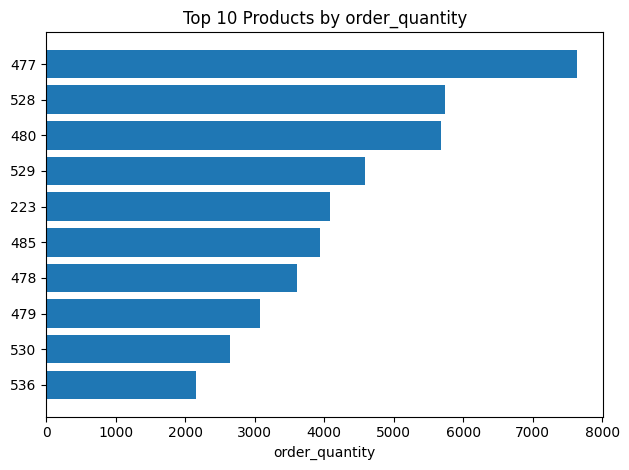

In [18]:
# Feature 1: Top products (revenue preferred; else quantity)

# choose measure
metric = tot_col or qty_col
assert metric is not None, "Need a revenue or quantity column."

# choose product key
pkey = prod_col or pick(list(dfw.columns), ["product","Product"])
assert pkey is not None, "Need a product column."

top_prod = (dfw.groupby(pkey)[metric].sum()
              .sort_values(ascending=False)
              .head(10)
              .reset_index())
display(top_prod)

plt.figure()
plt.barh(top_prod[pkey].astype(str)[::-1], top_prod[metric].values[::-1])
plt.title(f"Top 10 Products by {metric}")
plt.xlabel(metric); plt.tight_layout(); plt.show()

In [19]:
share3 = 100 * top_prod[metric].head(3).sum() / max(dfw[metric].sum(), 1)
feature_1_insights = f"""
**Feature:** Top products by {metric}

• Clear head: top-3 ≈ {share3:.1f}% of total {metric.lower()}.
• Prioritise supply/marketing for these items; monitor substitution risk.
""".strip()

In [20]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### B.3 Explore Feature of Interest `\<put feature name here\>`

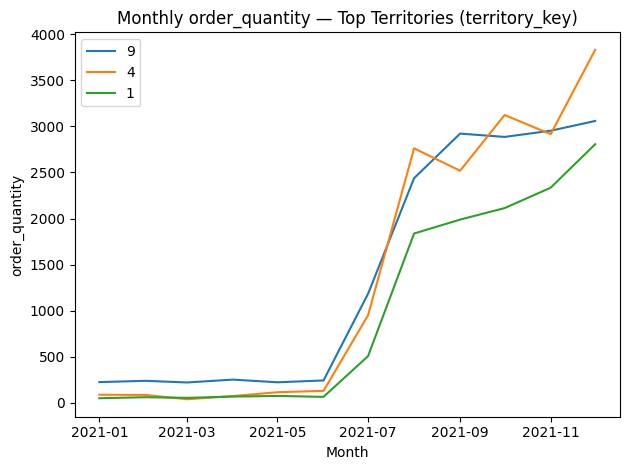

In [23]:
# Feature 2: Seasonality by territory (top-3 lines)

# pick geography label in business order
geo = pick(list(dfw.columns), ["Region","Country","Continent","SalesTerritoryKey", "territory_key"])
assert geo is not None, "Need a geography column (Region/Country/Continent/SalesTerritoryKey)."
assert "ym" in dfw.columns, "Need a month key; ensure OrderDate → ym earlier."

# build territory × month panel
panel = (dfw.groupby([geo,"ym"])[metric].sum().reset_index(name="monthly_val"))

# top-3 territories by total
top3 = (panel.groupby(geo)["monthly_val"].sum()
          .sort_values(ascending=False).head(3).index.tolist())

plt.figure()
for g in top3:
    s = panel.loc[panel[geo]==g, ["ym","monthly_val"]].sort_values("ym")
    plt.plot(s["ym"], s["monthly_val"], label=str(g))
plt.title(f"Monthly {metric} — Top Territories ({geo})")
plt.xlabel("Month"); plt.ylabel(metric)
plt.legend(); plt.tight_layout(); plt.show()

# small summaries for the tile
monthly_all = (dfw.groupby("ym")[metric].sum().reset_index(name="monthly_total"))
top_territories = ", ".join(map(str, top3))

In [24]:
mom = monthly_all["monthly_total"].pct_change().replace([np.inf,-np.inf], np.nan)
feature_2_insights = f"""
**Feature:** Seasonality by `{geo}`

• Median MoM change ≈ {np.nanmedian(mom):.2f}; volatility (std) ≈ {monthly_all['monthly_total'].std():.1f}.
• Top territories (total {metric.lower()}): {top_territories}.
• Add month/quarter dummies + 1–3 lags in models; watch for structural shifts in top regions.
""".strip()

In [25]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### B.4 Explore Feature of Interest `\<put feature name here\>`

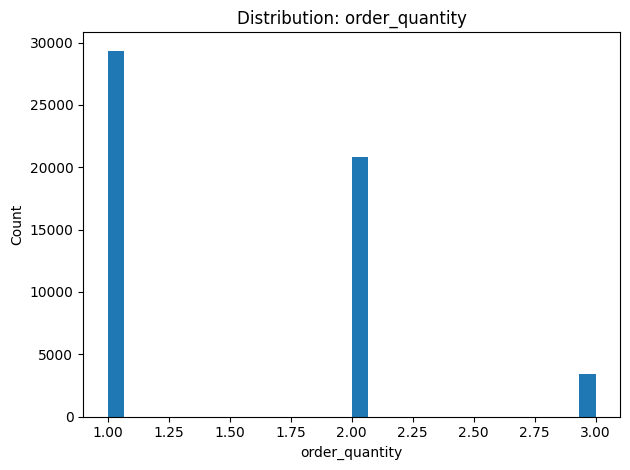

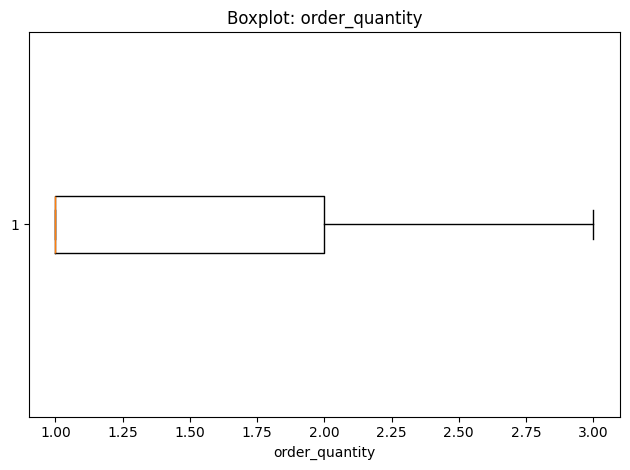

In [29]:
# Feature 3: Order Quantity distribution

# Use order_quantity as the feature to explore
feat = qty_col
assert feat is not None, "Need a quantity column to explore its distribution."

s = pd.to_numeric(dfw[feat], errors="coerce")

# histogram
plt.figure()
s.dropna().plot(kind="hist", bins=30)
plt.title(f"Distribution: {feat}")
plt.xlabel(feat); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# boxplot for outliers
plt.figure()
plt.boxplot(s.dropna(), vert=False, whis=1.5)
plt.title(f"Boxplot: {feat}")
plt.xlabel(feat); plt.tight_layout(); plt.show()

In [32]:

feature_n_insights = """
**Feature:** Order Quantity Distribution

- histogram shows that the majority of orders have a small quantity (1 or 2 items), with a long tail extending to higher quantities.
- boxplot confirms the presence of outliers with significantly higher order quantities.
- his suggests that while most transactions are for a few items, there are occasional large orders that could be important to understand further.
""".strip()

In [33]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)